In [1]:
import pandas as pd 
import numpy as np 
import cv2 # Used to manipulated the images 


In [2]:
train = pd.read_json('../data/train.json')

(1604, 5625)
(1604, 5625)
(1604, 11250)
(75, 75, 3)


ValueError: Floating point image RGB values must be in the 0..1 range.

(75, 75)


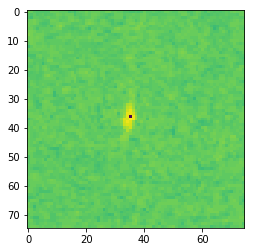

(75, 75)


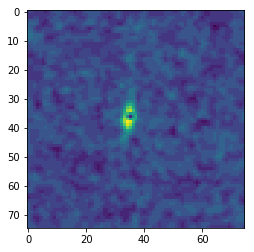

(75, 75)


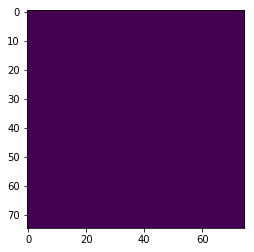

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

x_band1 = np.array([np.array(band).astype(np.float32) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32) for band in train["band_2"]])

print(x_band1.shape)
print(x_band2.shape)
images = np.column_stack((x_band1,x_band2))
print(images.shape)

imgs = []
r = np.array(train['band_1'][0]).reshape(75, 75)
g = np.array(train['band_2'][0]).reshape(75, 75)
b = np.divide(r,g, out=np.zeros_like(r), where=g!=0)
#imgs.append(np.dstack((r, g, b)))
img = np.dstack((r, g, b))
print(img.shape)
plt.imshow(img)
plt.show()
grey = cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2GRAY)
plt.imshow(grey)
print(grey.shape)
plt.show()
gb = cv2.GaussianBlur(grey, (3, 3), 0)
plt.imshow(gb)
print(gb.shape)
plt.show()

ce = cv2.Canny(gb, 5, 150)
plt.imshow(ce)
print(ce.shape)
plt.show()

In [6]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

In [8]:
Xtrain = get_scaled_imgs(train)

In [9]:
Ytrain = np.array(train['is_iceberg'])

In [11]:
train.inc_angle = train.inc_angle.replace('na',0)
idx_tr = np.where(train.inc_angle>0)

In [12]:
Ytrain = Ytrain[idx_tr[0]]
Xtrain = Xtrain[idx_tr[0],...]

In [13]:
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [14]:
Xtr_more = get_more_images(Xtrain) 

In [15]:
Ytr_more = np.concatenate((Ytrain,Ytrain,Ytrain))

In [16]:
def getModel():
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [17]:
model = getModel()
model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('../models/model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

NameError: name 'Sequential' is not defined

In [14]:
model.fit(Xtr_more, Ytr_more, batch_size=batch_size, epochs=50, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)


Train on 3309 samples, validate on 1104 samples
Epoch 1/50
3309/3309 [==============================] - 131s 40ms/step - loss: 0.5477 - acc: 0.7078 - val_loss: 0.3684 - val_acc: 0.8370
Epoch 2/50
3309/3309 [==============================] - 136s 41ms/step - loss: 0.3676 - acc: 0.8474 - val_loss: 0.3080 - val_acc: 0.8750
Epoch 3/50
3309/3309 [==============================] - 135s 41ms/step - loss: 0.3414 - acc: 0.8507 - val_loss: 0.3709 - val_acc: 0.8333
Epoch 4/50
3309/3309 [==============================] - 129s 39ms/step - loss: 0.2882 - acc: 0.8728 - val_loss: 0.2643 - val_acc: 0.8986
Epoch 5/50
3309/3309 [==============================] - 129s 39ms/step - loss: 0.2438 - acc: 0.8954 - val_loss: 0.2339 - val_acc: 0.9158
Epoch 6/50
3309/3309 [==============================] - 127s 39ms/step - loss: 0.2205 - acc: 0.9093 - val_loss: 0.2273 - val_acc: 0.9149
Epoch 7/50
3309/3309 [==============================] - 126s 38ms/step - loss: 0.2120 - acc: 0.9133 - val_loss: 0.2566 - val_acc: 

In [15]:
model.load_weights(filepath = '../models/model.hdf5')

score = model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1471/1471 [==============================] - 17s 12ms/step
Train score: 0.127967223464
Train accuracy: 0.955812371928


In [16]:
Xtest = (get_scaled_imgs(df_test))
pred_test = model.predict(Xtest)

submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission)


            id    is_iceberg
0     5941774d  1.143101e-01
1     4023181e  9.744909e-01
2     b20200e4  6.057059e-02
3     e7f018bb  9.987123e-01
4     4371c8c3  9.819810e-01
5     a8d9b1fd  1.659407e-01
6     29e7727e  1.869725e-01
7     92a51ffb  9.983988e-01
8     c769ac97  3.690912e-05
9     aee0547d  2.276588e-05
10    565b28ac  2.221289e-08
11    e04e9775  9.606348e-01
12    8e8161d1  1.627506e-03
13    4cf4d256  8.778560e-01
14    139e5324  4.091966e-01
15    f156976f  5.301872e-02
16    68a117cc  1.548032e-01
17    d9aa7a56  4.815563e-01
18    9005b143  2.191441e-01
19    5f6d3988  9.645306e-01
20    9ad70954  4.417958e-01
21    b9087b9e  5.729984e-01
22    a39a1427  7.617679e-02
23    82fbe8ed  2.172954e-01
24    1fae4879  2.451432e-07
25    6dd8f13d  2.530451e-04
26    bbad5958  2.925577e-01
27    54527583  3.891438e-01
28    be8fa29c  3.245075e-01
29    81a3328f  9.989707e-01
...        ...           ...
8394  8ae30ce6  2.448248e-03
8395  de27ed88  1.932846e-03
8396  66d5196f

In [17]:
submission.to_csv('../submission/submission6.csv', index=False)